<a href="https://colab.research.google.com/github/renewable-energy-experiments/carbonfoorprint/blob/master/CarbonEmission_fuelmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Electricity generation by energy source grids and Carbon Emissions <center><h1>  
<h2> Includes Carbon Life Cyccle Emission from Renewables </h2>

# Table of Contents
* [1. DataSet Description](#section-one)
* [2. Plot Generation graph](#section-two)
* [3. Carbon Emissions](#section-three)
* [4. Carbon graph](#section-four)

In [546]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

<a id="section-one"></a>
# 1. DataSet Description

Dataset is weekly reports from EDA  for CA ISO

In [547]:
# Import generation  data 

Region="UK"
date = datetime.date(2020, 7, 6)

# NYISO
# df = pd.read_csv("/content/CA ISO_2020-09-07.csv")

# New England
# df = pd.read_csv("/content/NewEngland_2020-07-11.csv")

# North West BPA 
# North Western BPA https://transmission.bpa.gov/business/operations/Wind/baltwg.aspx
# df = pd.read_csv('/content/baltwg_16_23_jun_2021.txt', 
#                 #  skiprows=[0,1], 
#                  sep = "\t",delimiter = "\t")

# CA ISO 
# df = pd.read_csv("/content/CA ISO_2020-11-07.csv")

# Texas
# df = pd.read_csv("/content/CA ISO_2020-09-07.csv")

# Canada
# df = pd.read_csv("/content/xml-to-csv-generation_fuel_type_multiday.csv")

# UK
df = pd.read_csv("/content/GenerationbyFuelType_20210615_1905.csv")


df.head()

HDR  HALF HOURLY OUTTURN GENERATION BY FUEL TYPE DATA
FUELHH 20200706 1.0 3403.0 0.0 0.0 5278.0 9815.0 0.0 311.0 0.0 111.0 0.0 66.0 0.0 208.0 923.0 0.0 0.0  0.0                                               0.0
                2.0 3394.0 0.0 0.0 5274.0 9494.0 0.0 302.0 0.0 111.0 0.0 72.0 0.0 186.0 910.0 0.0 0.0  0.0                                               0.0
                3.0 3422.0 0.0 0.0 5258.0 9282.0 0.0 279.0 0.0 126.0 0.0 0.0  0.0 336.0 908.0 0.0 0.0  0.0                                               0.0
                4.0 3291.0 0.0 0.0 5261.0 9279.0 0.0 276.0 0.0 113.0 0.0 0.0  0.0 458.0 908.0 0.0 0.0  0.0                                               0.0
                5.0 3268.0 0.0 0.0 5246.0 9385.0 0.0 245.0 0.0 120.0 0.0 0.0  0.0 366.0 909.0 0.0 0.0  0.0                                               0.0

In [548]:
column_list = ("Nuclear","Wind","Solar","Hydro","Other",  "Oil", "NaturalGas","Coal")

def df_manipulation_casio(dfs):
    dfs['Timestamp'] = dfs.index
    date =  dfs.iloc[0].Timestamp.replace('Supply ','')
    dfs['DATE'] = date
    dfs = dfs[1:len(dfs)-1]
    dfs['DATE'] =  pd.to_datetime(dfs['DATE'],format = '%m/%d/%Y').dt.date
    dfs['TIME'] = pd.to_datetime(dfs['Timestamp'],format = '%H:%M').dt.time
    dfs['HOURS'] = pd.to_datetime(dfs['TIME'],format='%H:%M:%S').dt.hour
    dfs['MINUTES'] = pd.to_datetime(dfs['TIME'],format='%H:%M:%S').dt.minute
    dfs['MINUTES_PASS'] = dfs['MINUTES'] + dfs['HOURS']*60
    dfs['Timestamp'] = pd.to_datetime(dfs['DATE'].apply(str) +' '+ dfs['TIME'].apply(str), format = '%Y-%m-%d %H:%M:%S')

      # Fill up Nan as 0
    dfs = dfs.replace('undefined', 0)
    dfs = dfs.fillna(0)
    dfs = dfs.replace(np.nan, 0)

    return dfs

def df_manipulation_northwest(dfs):
    dfs = dfs.rename(columns={"Fossil/Biomass": "NaturalGas",
                            "Large hydro": "Hydro"
                          })
    for col in column_list:
      if col not in dfs.columns:
          dfs[col] = 0
    dfs["total_generation"] = dfs[np.array(column_list)].sum(axis=1)
    dfs['Timestamp'] = pd.to_datetime(dfs['Date/Time       '], format = '%m/%d/%Y %H:%M')
                  
    # adding separate time and date columns
    dfs["DATE"] = pd.to_datetime(dfs["Timestamp"]).dt.date # add new column with date
    dfs['TIME'] = pd.to_datetime(dfs['Timestamp'],format = '%H:%M').dt.time
    dfs['HOURS'] = pd.to_datetime(dfs['TIME'],format='%H:%M:%S').dt.hour
    dfs['MINUTES'] = pd.to_datetime(dfs['TIME'],format='%H:%M:%S').dt.minute
    dfs['MINUTES_PASS'] = dfs['MINUTES'] + dfs['HOURS']*60

    # Fill up Nan as 0
    dfs = dfs.replace('undefined', 0)
    dfs = dfs.fillna(0)
    dfs = dfs.replace(np.nan, 0)

    # drop BeginDate
    dfs.drop('Date/Time       ', axis=1, inplace=True)
    day1 = dfs[dfs['DATE']== date].reset_index()

    return day1

def df_manipulation_isone(dfs):

    return dfs

def df_manipulation_caiso(dfs):

    return dfs

def df_manipulation_canada(dfs):
    cols = list(dfs.columns)
    cols = [cols[-1]] + cols[:-1]
    dfs = dfs[cols]

    dfs.reset_index(inplace=True)
    dfs.set_index('_Series', drop=True, inplace=True)
    dfs= dfs.transpose()
    dfs = dfs[1:]

    dfs['Timestamp']=pd.date_range(start='2020-06-10', freq='1H', end='2020-06-16')
    dfs = dfs.rename(columns={"Date" : "DATE",
                        "Hour" : "HOUR",
                        "GAS": "NaturalGas",
                        "SOLAR" : "Solar",
                        "NUCLEAR" : "Nuclear",
                        "WIND" : "Wind",
                        "HYDRO": "Hydro",
                        "BIOFUEL": "Other",
                        "Total Output":"total_generation"
                       })
    dfs['DATE'] =  pd.to_datetime(dfs['Timestamp'],format = '%Y-%m-%d', errors='coerce').dt.date
    dfs['TIME'] = pd.to_datetime(dfs['Timestamp'],format = '%H:%M', errors='coerce').dt.time 
    dfs['HOURS'] = pd.to_datetime(dfs['Timestamp'],format = '%H', errors='coerce').dt.hour
    dfs['MINUTES'] = pd.to_datetime(dfs['Timestamp'],format='%M' , errors='coerce').dt.minute
    dfs['MINUTES_PASS'] = dfs['MINUTES'] + dfs['HOURS']*60

    for col in column_list:
        if col not in dfs.columns:
            dfs[col] = 0

    dfs['Nuclear'] = pd.to_numeric(dfs['Nuclear'], errors='coerce').fillna(0)
    dfs['Hydro'] = pd.to_numeric(dfs['Hydro'], errors='coerce').fillna(0)
    dfs['NaturalGas'] = pd.to_numeric(dfs['NaturalGas'], errors='coerce').fillna(0)
    dfs['Coal'] = pd.to_numeric(dfs['Coal'], errors='coerce').fillna(0)
    dfs['Solar'] = pd.to_numeric(dfs['Solar'], errors='coerce').fillna(0)
    dfs['Coal'] = pd.to_numeric(dfs['Coal'], errors='coerce').fillna(0)
    dfs['Oil'] = pd.to_numeric(dfs['Oil'], errors='coerce').fillna(0)
    dfs['Other'] = pd.to_numeric(dfs['Other'], errors='coerce').fillna(0)
    dfs["total_generation"] = dfs[np.array(column_list)].sum(axis=1)

    dfs = dfs[dfs['DATE']==date]
    return dfs

def df_manipulation_uk(dfs):
    col_names = ['','Timestamp','MINUTES','NaturalGas', 'Oil', 'Coal', 'Nuclear', 'Wind','','Hydro','','Other','','','','','','','']
    dfs = pd.DataFrame(dfs.index.values.tolist(), columns=col_names)

    for col in column_list:
        if col not in dfs.columns:
            dfs[col] = 0
    # dfs['Timestamp'] = pd.date_range(start='2020-07-06', freq='1H', end='2020-07-12')
    dfs['DATE'] =  pd.to_datetime(dfs['Timestamp'], errors='coerce', format = '%Y%m%d').dt.date
    dfs["total_generation"] = dfs[np.array(column_list)].sum(axis=1)

    df2 = pd.DataFrame()

    dhours = dfs[dfs['DATE']==date]
    dunique_minpass = dhours['Timestamp'].unique()
    dunique_minpass = pd.to_datetime(dunique_minpass ,format = '%Y-%m-%d %H:%M')
    
    index = pd.date_range(date, periods=1440, freq='T')
    series = pd.Series(range(1440), index=index, name='Timestamp')
    series = pd.to_datetime(series.index,format = '%Y-%m-%d %H:%M')

    for m in series: 
        if m not in dunique_minpass:
            dhours = dhours.append({ 
                'Timestamp': m,
                'Solar': 0
            }, ignore_index = True) 
    dhours = dhours.interpolate(method ='linear', limit_direction ='forward')
    df2 = df2.append(dhours)

    # convert minutes ( 30 min apart to hours)
    df2['HOURS'] = pd.to_datetime(df2['MINUTES']/2,errors ="coerce",format='%H').dt.hour
    df2['HOURS'] = df2['HOURS'] .replace(np.nan, 24)

    df2 = df2.replace('undefined', 0)
    df2 = df2.fillna(0)
    df2 = df2.replace(np.nan, 0)
    # drop unrecognized fuel types and empty column header columns
    df2.drop([''], axis=1, inplace=True)  

    df2['MINUTES_PASS'] = df2['MINUTES'] + df2['HOURS']*60

    return df2

In [549]:
# df = df_manipulation_northwest(df)
# df = df_manipulation_isone(df)

# df = df_manipulation_canada(df)

# df = df_manipulation_caiso(df)

df = df_manipulation_uk(df)
df.head()

,Timestamp,MINUTES,NaturalGas,Oil,Coal,Nuclear,Wind,Hydro,Other,Solar,DATE,total_generation,HOURS,MINUTES_PASS
0,20200706,1.0,3403.0,0.0,0.0,5278.0,9815.0,311.0,111.0,0,2020-07-06,18918.0,0.0,1.0
1,20200706,2.0,3394.0,0.0,0.0,5274.0,9494.0,302.0,111.0,0,2020-07-06,18575.0,1.0,62.0
2,20200706,3.0,3422.0,0.0,0.0,5258.0,9282.0,279.0,126.0,0,2020-07-06,18367.0,1.0,63.0
3,20200706,4.0,3291.0,0.0,0.0,5261.0,9279.0,276.0,113.0,0,2020-07-06,18220.0,2.0,124.0
4,20200706,5.0,3268.0,0.0,0.0,5246.0,9385.0,245.0,120.0,0,2020-07-06,18264.0,2.0,125.0


In [550]:
df_carbon = pd.read_csv("/content/US Utility grids - LCOE, Co2 Emissions - Carbon3.csv")
df_carbon

,Fuel Type,Lifecycle emissions (gCO2eq/kWh),Lifecycle emissions (kgCO2eq/MWh)
0,Nuclear,12,12
1,Hydro,24,24
2,Wind,12,12
3,Solar,48,48
4,NaturalGas,490,490
5,Oil,490,490
6,Coal,820,820
7,Other,24,24


<a id="section-two"></a>
# 2. Plot Generation graph

In [551]:
color_list = ["green","skyblue","gold","teal","deeppink","red","brown","darkgrey"]

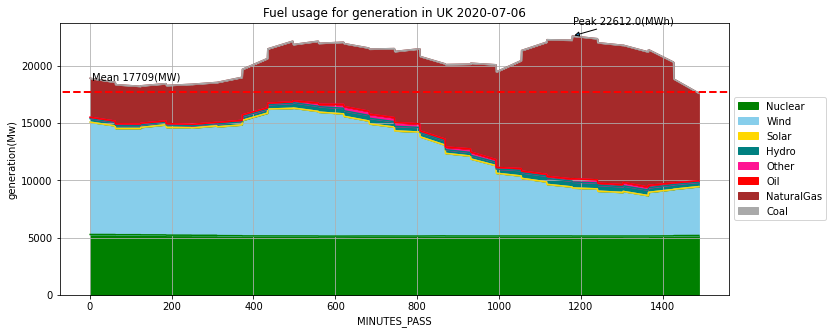

In [552]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

df.plot(x='MINUTES_PASS', y = np.array(column_list), 
             ax = ax, 
             kind='area', stacked=True, 
             color = np.array(color_list),
             title = "Fuel usage for generation in "+ Region + " "+  str(date), 
             grid=True,legend=False)

ax.set_ylabel("generation(Mw)")

mean_gen = round(df["total_generation"].mean())
max_gen = df["total_generation"].max()
maxh = df.loc[df["total_generation"]== max_gen]
maxh = maxh["MINUTES_PASS"]
ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)

ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MW)" )

#     ax.get_legend().remove()

ax.annotate('Peak '+ str(max_gen)+ "(MWh)", xy=(maxh,max_gen), xytext=(maxh+1, max_gen+1000),
          arrowprops=dict(arrowstyle='-|>') ,ha='left', rotation=0)

# ax.set_ylim(bottom = 0,top=39000)
    
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [553]:
maxgen = df["total_generation"].max()
maxhour = df.loc[df["total_generation"]== maxgen]["HOURS"]
peakhour = df[ df['HOURS'].values == maxhour.values ]
dfpeakfuelmix = pd.DataFrame(peakhour[np.array(column_list)].sum(numeric_only=True, axis=0))

for col in dfpeakfuelmix.columns:
    dfpeakfuelmix = dfpeakfuelmix.rename(columns={col:'peak generation'})

dfpeakfuelmix["percent"] = (dfpeakfuelmix['peak generation'] / dfpeakfuelmix['peak generation'].sum()) * 100
dfpeakfuelmix["percent"] = dfpeakfuelmix["percent"].round(3)

dfpeakfuelmix

,peak generation,percent
Nuclear,10293.0,22.944
Wind,8481.0,18.905
Solar,0.0,0.000
Hydro,1031.0,2.298
Other,482.0,1.074
Oil,0.0,0.000
NaturalGas,24575.0,54.779
Coal,0.0,0.000


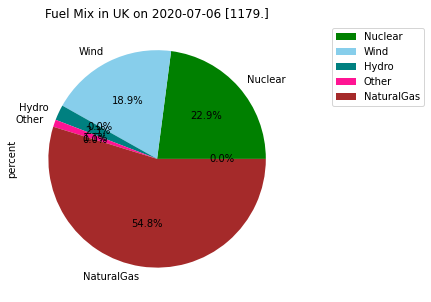

In [554]:
pie= dfpeakfuelmix.plot.pie(y='percent',title="Fuel Mix in "+ Region + " on "+ str(date) + " " + str(maxh.values) , 
                            colors= np.array(color_list),
                            autopct='%1.1f%%',
                            figsize=(5, 5))
pie.legend(bbox_to_anchor=(1.5,1), loc="bottom right")

<a id="section-three"></a>
# 3. Carbon Emissions

In [555]:
for col in df.columns:
    # print(df[col])
    for j,carbon in df_carbon.iterrows():
        if col in carbon[0]:
            print("Match between two tables for "+col+ " and "+ carbon[0] +" - "+ str(carbon[1]))
            df['carbon_'+col] = df[col] * carbon[1]
            
df.head()

Match between two tables for NaturalGas and NaturalGas - 490
Match between two tables for Oil and Oil - 490
Match between two tables for Coal and Coal - 820
Match between two tables for Nuclear and Nuclear - 12
Match between two tables for Wind and Wind - 12
Match between two tables for Hydro and Hydro - 24
Match between two tables for Other and Other - 24
Match between two tables for Solar and Solar - 48


,Timestamp,MINUTES,NaturalGas,Oil,Coal,Nuclear,Wind,Hydro,Other,Solar,DATE,total_generation,HOURS,MINUTES_PASS,carbon_NaturalGas,carbon_Oil,carbon_Coal,carbon_Nuclear,carbon_Wind,carbon_Hydro,carbon_Other,carbon_Solar
0,20200706,1.0,3403.0,0.0,0.0,5278.0,9815.0,311.0,111.0,0,2020-07-06,18918.0,0.0,1.0,1667470.0,0.0,0.0,63336.0,117780.0,7464.0,2664.0,0
1,20200706,2.0,3394.0,0.0,0.0,5274.0,9494.0,302.0,111.0,0,2020-07-06,18575.0,1.0,62.0,1663060.0,0.0,0.0,63288.0,113928.0,7248.0,2664.0,0
2,20200706,3.0,3422.0,0.0,0.0,5258.0,9282.0,279.0,126.0,0,2020-07-06,18367.0,1.0,63.0,1676780.0,0.0,0.0,63096.0,111384.0,6696.0,3024.0,0
3,20200706,4.0,3291.0,0.0,0.0,5261.0,9279.0,276.0,113.0,0,2020-07-06,18220.0,2.0,124.0,1612590.0,0.0,0.0,63132.0,111348.0,6624.0,2712.0,0
4,20200706,5.0,3268.0,0.0,0.0,5246.0,9385.0,245.0,120.0,0,2020-07-06,18264.0,2.0,125.0,1601320.0,0.0,0.0,62952.0,112620.0,5880.0,2880.0,0


In [556]:
column_list_carbon = ("carbon_Nuclear","carbon_Wind","carbon_Solar","carbon_Hydro", "carbon_Other", 
                "carbon_NaturalGas","carbon_Oil","carbon_Coal")

In [557]:
df['carbon_total_emission']= df[np.array(column_list_carbon)].sum(axis=1)
df.head()

,Timestamp,MINUTES,NaturalGas,Oil,Coal,Nuclear,Wind,Hydro,Other,Solar,DATE,total_generation,HOURS,MINUTES_PASS,carbon_NaturalGas,carbon_Oil,carbon_Coal,carbon_Nuclear,carbon_Wind,carbon_Hydro,carbon_Other,carbon_Solar,carbon_total_emission
0,20200706,1.0,3403.0,0.0,0.0,5278.0,9815.0,311.0,111.0,0,2020-07-06,18918.0,0.0,1.0,1667470.0,0.0,0.0,63336.0,117780.0,7464.0,2664.0,0,1858714.0
1,20200706,2.0,3394.0,0.0,0.0,5274.0,9494.0,302.0,111.0,0,2020-07-06,18575.0,1.0,62.0,1663060.0,0.0,0.0,63288.0,113928.0,7248.0,2664.0,0,1850188.0
2,20200706,3.0,3422.0,0.0,0.0,5258.0,9282.0,279.0,126.0,0,2020-07-06,18367.0,1.0,63.0,1676780.0,0.0,0.0,63096.0,111384.0,6696.0,3024.0,0,1860980.0
3,20200706,4.0,3291.0,0.0,0.0,5261.0,9279.0,276.0,113.0,0,2020-07-06,18220.0,2.0,124.0,1612590.0,0.0,0.0,63132.0,111348.0,6624.0,2712.0,0,1796406.0
4,20200706,5.0,3268.0,0.0,0.0,5246.0,9385.0,245.0,120.0,0,2020-07-06,18264.0,2.0,125.0,1601320.0,0.0,0.0,62952.0,112620.0,5880.0,2880.0,0,1785652.0


<a id="section-four"></a>
# 4. Carbon Graphs

In [558]:
subdfcarbon = pd.DataFrame(df[np.array(column_list_carbon)].sum(numeric_only=True, axis=0))

for col in subdfcarbon.columns:
    subdfcarbon = subdfcarbon.rename(columns={col:'carbon emission'})

subdfcarbon["percent"] = (subdfcarbon['carbon emission'] / subdfcarbon['carbon emission'].sum()) * 100
subdfcarbon["percent"] = subdfcarbon["percent"].round(3)

subdfcarbon

,carbon emission,percent
carbon_Nuclear,9.267764e+07,1.612
carbon_Wind,7.822189e+07,1.361
carbon_Solar,0.000000e+00,0.000
carbon_Hydro,1.409791e+07,0.245
carbon_Other,4.198848e+06,0.073
carbon_NaturalGas,5.560263e+09,96.709
carbon_Oil,0.000000e+00,0.000
carbon_Coal,0.000000e+00,0.000


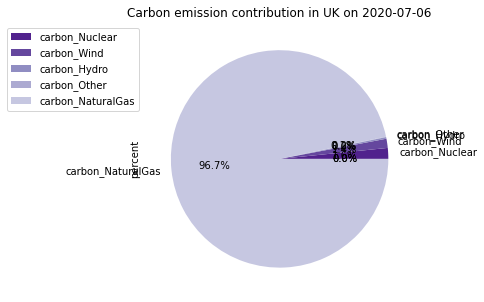

In [559]:
cmap = sns.color_palette("Purples_r", n_colors=8)
carbonpie = subdfcarbon[0:8].plot.pie(y='percent',title="Carbon emission contribution in "+ Region + " on "+ str(date) , 
                            colors= cmap,
                            autopct='%1.1f%%',
                            figsize=(5, 5))
carbonpie.legend(bbox_to_anchor=(0,1), loc="bottom right")

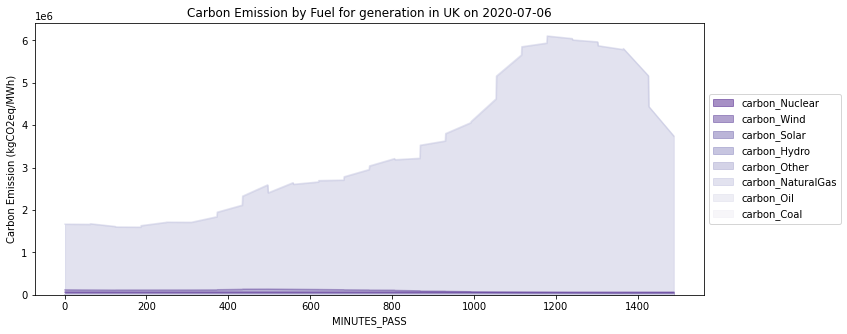

In [560]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df.plot(x='MINUTES_PASS', y = np.array(column_list_carbon), 
            ax = ax, 
             color=cmap, 
              kind='area', stacked=False,
              title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ str(date),legend=False)
ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")   
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

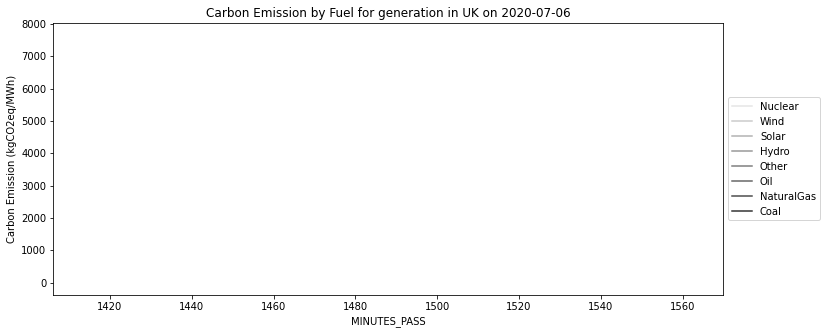

In [561]:
import seaborn as sns
cmap = sns.color_palette("gray_r", n_colors=9)

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df[200:600].plot(x='MINUTES_PASS', y = np.array(column_list), ax = ax, 
             color=cmap, 
              # kind='area', stacked=False,
              title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ str(date),legend=False)
ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")   
# ax.set_ylim(bottom = 0,top=50000)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

NameError: ignored

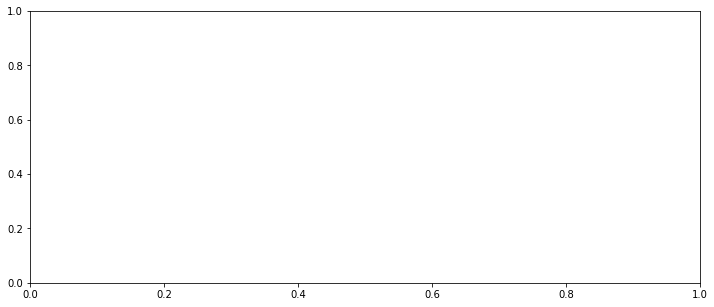

In [562]:
import seaborn as sns
cmap = sns.color_palette("Blues_r", n_colors=4)

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df.plot(x='MINUTES_PASS', y = np.array(column_list)[0:4], ax = ax, 
             color=cmap, 
              # kind='area', stacked=False,
              title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ pp,legend=False)
ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")   
# ax.set_ylim(bottom = 0,top=50000)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
## Without total carbon emission 
import seaborn as sns
cmap = sns.color_palette("gray_r", n_colors=8)

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df.plot(x='MINUTES_PASS', y = np.array(column_list)[0:8], ax = ax, 
             color=cmap, 
              kind='area', stacked=True,
              title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ pp,legend=False)
ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
## With total carbon emission 
import seaborn as sns
cmap = sns.color_palette("gray_r", n_colors=9)

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df.plot(x='MINUTES_PASS', y = np.array(column_list), ax = ax, 
             color=cmap, 
          kind='area', stacked=True,
              title = "Carbon Emission by Fuel for generation in "+ Region + " on "+ pp,legend=False)
ax.set_ylabel("Carbon Emission (kgCO2eq/MWh)")

# mean_gen = round(sub_df["total_generation"].mean())
# max_gen = sub_df["total_generation"].max()
# maxh = sub_df.loc[sub_df["total_generation"]== max_gen]
# maxh = maxh["HOURS"]

# Mark Mean Line 
# ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
# ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MW)" )

# ax.get_legend().remove()

# Mark Peak consumption 
# ax.annotate('Peak '+ str(max_gen)+ "(MWh)", xy=(maxh,max_gen), xytext=(maxh+1, max_gen+1000),
#              arrowprops=dict(arrowstyle='-|>') ,ha='left', rotation=0)
    
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plot.show(block=True);

In [ ]:
# fig, axs = plt.subplots(nrows=3, ncols=2)
# fig.set_size_inches(20, 10)
# fig.subplots_adjust(wspace=0.2)
# fig.subplots_adjust(hspace=0.5)

# fig.legend(column_list)
  
# for pp,ax in zip(dates,axs.flatten()):
#     print(pp)
#     sub_df = df[df['DATE']==pp]
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[0], ax = ax, title = "Fuel Mix for generation in "+ Region + " on "+ pp,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[1], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[2], ax = ax,legend=False)    
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[3], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[4], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[5], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[6], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y = column_list[7], ax = ax,legend=False)
#     sub_df.plot.line(x='MINUTES_PASS', y =['total_generation'], ax = ax,legend=False)
    
#     ax.set_ylabel("generation(Mw)")
    
#     mean_gen = round(sub_df["total_generation"].mean())
#     max_gen = sub_df["total_generation"].max()
#     maxh = sub_df.loc[sub_df["total_generation"]== max_gen]
#     maxh = maxh["MINUTES_PASS"]
#     ax.axhline(y=mean_gen, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
    
#     ax.text(5,mean_gen+1000, "Mean " + str(mean_gen) + "(MW)" )

# #     ax.get_legend().remove()
    
# #     ax.annotate('Peak '+ str(max_gen)+ "(MWh)", xy=(maxh,max_gen), xytext=(maxh+1, max_gen+1000),
# #              arrowprops=dict(arrowstyle='-|>') ,ha='left', rotation=0)
    
#     ax.set_ylim(bottom = 0,top=39000)
    
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))